In [60]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns
import matplotlib.pyplot as plt

## Retrieving largest subreddits by subscriber count

In [10]:
def biggest_subreddits(pages=2):
    most_subscribed_subreddits=[]
    
    redditlist_pages = []

    for i in range(1, pages):
        url = 'http://redditlist.com/?page=' + str(i) + ''
        redditlist_pages.append(url)
        
    for item in redditlist_pages:
        
        page = requests.get(item)
        soup = BeautifulSoup(page.text, 'html.parser')
        
        subreddits = soup.find_all(class_='listing-item')
        
        subreddit_names = []

        for subreddit in subreddits:
            subreddit_names.append(subreddit.attrs['data-target-subreddit'])
        
        #picks the values from the middle list containing the most subscribers. Not recent activity or Growth (24Hrs) 
        most_subscribed_subreddits = most_subscribed_subreddits + subreddit_names[125:250]
        
        
    return most_subscribed_subreddits

def subreddits_to_csv(subreddits, name):
    df = pd.DataFrame(subreddits, columns=["subreddit"])
    df.to_csv(name, index=False)    

In [118]:
subreddits = biggest_subreddits(9)

In [357]:
subreddits_to_csv(subreddits, 'cvs/thousand_biggest_subreddits.csv')

In [358]:
top_thousand_subreddits = pd.read_csv('cvs/thousand_biggest_subreddits.csv')
top_thousand_subreddits.head()

,subreddit
0,funny
1,AskReddit
2,gaming
3,pics
4,science


## Retrieving yearly top posts 

In [153]:
#private praw api key needed
#Alternatively there are csv files with top post and calculated sentiment scores
praw_id = pd.read_csv('api_keys.csv')
reddit = praw.Reddit(client_id=praw_id.client_id[0], \
                     client_secret=praw_id.client_secret[0], \
                     user_agent=praw_id.user_agent[0], \
                     username=praw_id.username[0], \
                     password=praw_id.password[0])

In [8]:
def subreddit_top_posts(subreddit, limit):
    subreddit = reddit.subreddit(subreddit)
    
    submissions = []
    
    for submission in subreddit.top('year', limit=limit):
            submissions.append(submission.title)
            
    return submissions

In [ ]:
dataisbeautiful = subreddit_top_posts('dataisbeautiful', 500)
politics = subreddit_top_posts('politics', 500)
aww = subreddit_top_posts('aww', 500)

In [133]:
#5 top posts by user score from the politics subreddit
for i in politics[:5]:
    print(i)

Kim Davis, clerk who refused to sign marriage licenses for gay couples, loses to Democrat
Ivanka Trump used a personal email account to send hundreds of emails about government business last year
F.B.I. Opened Inquiry Into Whether Trump Was Secretly Working on Behalf of Russia
McConnell blocks House bill to reopen government for second time
Megathread: President Trump Directed His Attorney To Lie To Congress About The Moscow Tower Project


## Calculating Vader sentiment scores for the different subreddits

In [189]:
def sentiment_scores(headings):
    sia = SIA()
    scores = []

    for heading in headings:
        pol_score = sia.polarity_scores(heading)
        pol_score['heading'] = heading
        scores.append(pol_score)
    
    return scores

def aggregate_sentiment(scores, name):
 
    compound = scores[['compound']].mean().values[0]
    neg = scores[['neg']].mean().values[0]
    neu = scores[['neu']].mean().values[0]
    pos = scores[['pos']].mean().values[0]
 
    aggregated = {'subreddit' : name,'compound' : compound, 'neg' : neg, 'neu' : neu, 'pos' : pos}
    
    return aggregated


In [55]:
dataisbeautiful_sentiment = pd.DataFrame.from_records(sentiment_scores(top_posts))
politics_sentiment = pd.DataFrame.from_records(sentiment_scores(politics))
aww_sentiment = pd.DataFrame.from_records(sentiment_scores(aww))

In [362]:
dataisbeautiful_sentiment.to_csv('cvs/dataisbeautiful_sentiment.csv', index=False)
politics_sentiment.to_csv('cvs/politics_sentiment.csv', index=False)
aww_sentiment.to_csv('cvs/aww_sentiment.csv', index=False)

In [365]:
dataisbeautiful_sentiment = pd.read_csv('cvs/dataisbeautiful_sentiment.csv')
politics_sentiment = pd.read_csv('cvs/politics_sentiment.csv')
aww_sentiment = pd.read_csv('cvs/aww_sentiment.csv')

In [367]:
dataisbeautiful_sentiment.head()

,compound,heading,neg,neu,pos
0,-0.5994,Cause of Death - Reality vs. Google vs. Media ...,0.328,0.672,0.000
1,0.0000,Gaze and foot placement when walking over roug...,0.000,1.000,0.000
2,0.0000,"11 different brands of AA batteries, tested in...",0.000,1.000,0.000
3,0.3818,The City is Alive: The Population of Manhattan...,0.000,0.776,0.224
4,0.0000,Average flag colour by latitude [OC],0.000,1.000,0.000


In [184]:
politics_sentiment.head()

,compound,heading,neg,neu,pos
0,-0.5423,"Kim Davis, clerk who refused to sign marriage ...",0.257,0.743,0.0
1,0.0000,Ivanka Trump used a personal email account to ...,0.000,1.000,0.0
2,0.0000,F.B.I. Opened Inquiry Into Whether Trump Was S...,0.000,1.000,0.0
3,-0.2263,McConnell blocks House bill to reopen governme...,0.174,0.826,0.0
4,0.0000,Megathread: President Trump Directed His Attor...,0.000,1.000,0.0


In [366]:
aww_sentiment.head()

,compound,heading,neg,neu,pos
0,0.0000,Heat index was 110 degrees so we offered him a...,0.000,1.000,0.000
1,0.6249,"Kirk, a female Border Collie, watching herself...",0.000,0.662,0.338
2,0.2235,Nothing will stop this dog from protecting his...,0.000,0.809,0.191
3,0.4532,My 90yo neighbor hasn’t walked her dog in year...,0.087,0.753,0.161
4,0.4588,His favorite spot when traveling.,0.000,0.571,0.429


In [190]:
aggregate_sentiment(politics_sentiment, 'politics')

{'subreddit': 'politics',
 'compound': -0.0655532,
 'neg': 0.11278999999999999,
 'neu': 0.807578,
 'pos': 0.07962800000000002}

## Visualizing sentiment scores of individual subreddits

Text(0.5, 0.98, 'Compound sentiment score')

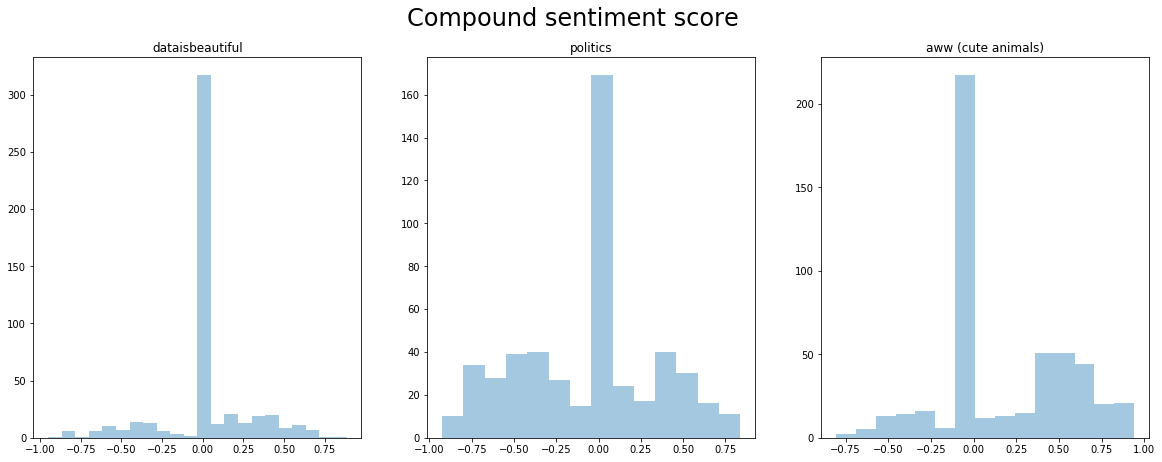

In [346]:
fig, axs = plt.subplots(ncols=3,figsize=(20,7))

sns.distplot(a=tuple(dataisbeautiful_sentiment['compound']),kde=False, rug=False, ax=axs[0]).set_title('dataisbeautiful')
sns.distplot(a=tuple(politics_sentiment['compound']), kde=False, rug=False, ax=axs[1]).set_title('politics')
sns.distplot(a=tuple(aww_sentiment['compound']), kde=False, rug=False, ax=axs[2]).set_title('aww (cute animals)')

fig.suptitle('Compound sentiment score', fontsize=24)

In [347]:
fig.savefig('pics/Compound sentiment score') 

Text(0.5, 0.98, 'Negative sentiment score')

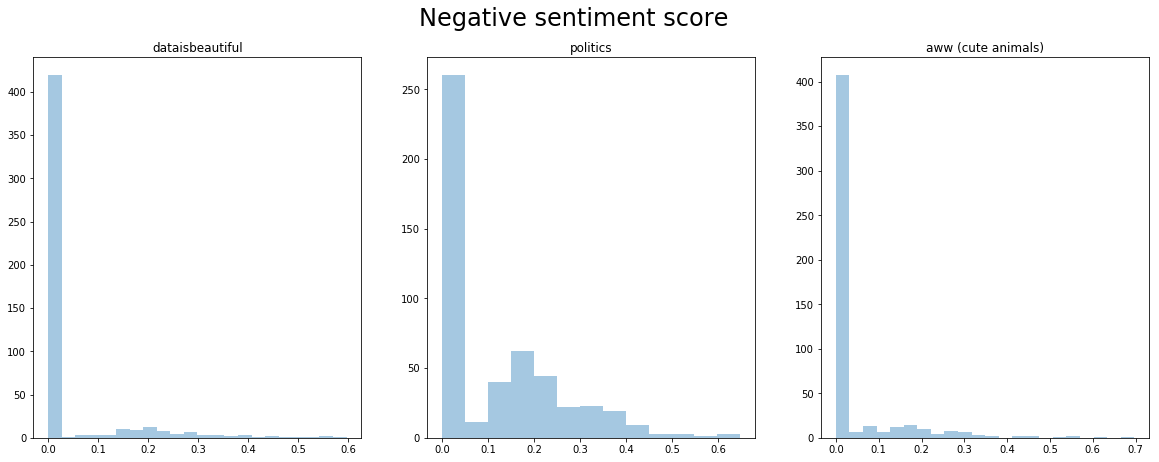

In [348]:
fig, axs = plt.subplots(ncols=3,figsize=(20,7))

sns.distplot(a=tuple(dataisbeautiful_sentiment['neg']), kde=False, rug=False, ax=axs[0]).set_title('dataisbeautiful')
sns.distplot(a=tuple(politics_sentiment['neg']), kde=False, rug=False, ax=axs[1]).set_title('politics')
sns.distplot(a=tuple(aww_sentiment['neg']), kde=False, rug=False, ax=axs[2]).set_title('aww (cute animals)')

fig.suptitle('Negative sentiment score', fontsize=24)

In [349]:
fig.savefig('pics/Negative sentiment score') 

Text(0.5, 0.98, 'Positive sentiment score')

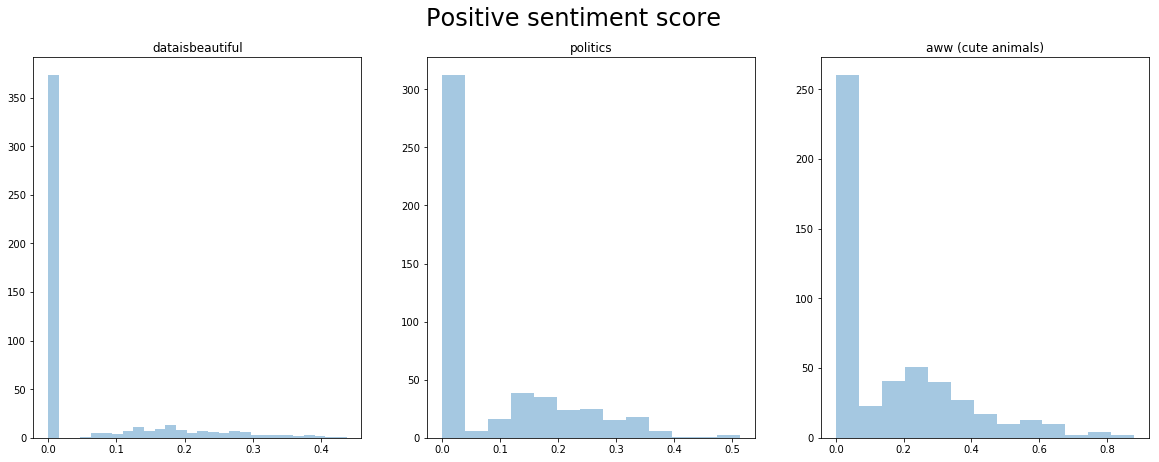

In [350]:
fig, axs = plt.subplots(ncols=3,figsize=(20,7))

sns.distplot(a=tuple(dataisbeautiful_sentiment['pos']), kde=False, rug=False, ax=axs[0]).set_title('dataisbeautiful')
sns.distplot(a=tuple(politics_sentiment['pos']), kde=False, rug=False, ax=axs[1]).set_title('politics')
sns.distplot(a=tuple(aww_sentiment['pos']), kde=False, rug=False, ax=axs[2]).set_title('aww (cute animals)')

fig.suptitle('Positive sentiment score', fontsize=24)

In [351]:
fig.savefig('pics/Positive sentiment score') 

Text(0.5, 0.98, 'Neutral sentiment score')

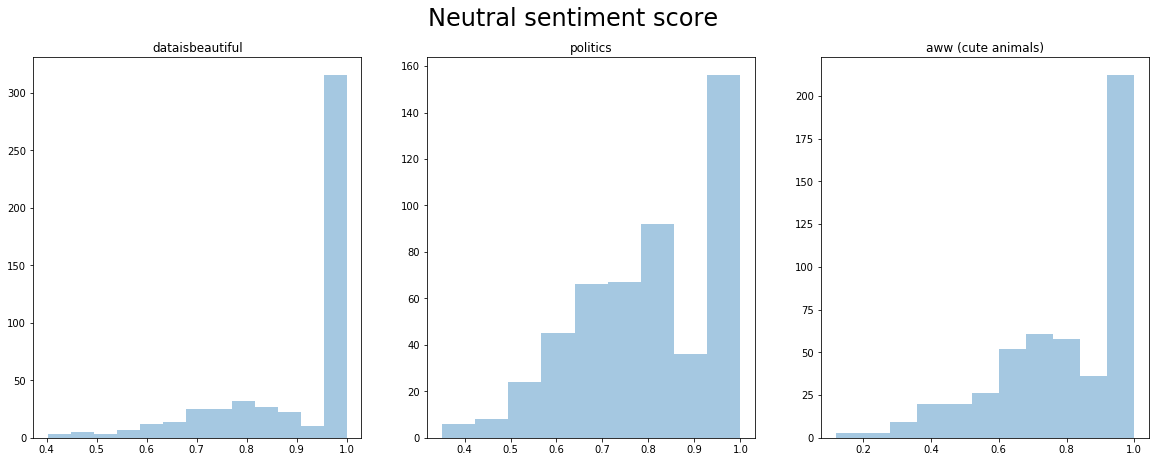

In [352]:
fig, axs = plt.subplots(ncols=3,figsize=(20,7))

sns.distplot(a=tuple(dataisbeautiful_sentiment['neu']), kde=False, rug=False, ax=axs[0]).set_title('dataisbeautiful')
sns.distplot(a=tuple(politics_sentiment['neu']), kde=False, rug=False, ax=axs[1]).set_title('politics')
sns.distplot(a=tuple(aww_sentiment['neu']), kde=False, rug=False, ax=axs[2]).set_title('aww (cute animals)')

fig.suptitle('Neutral sentiment score', fontsize=24)

In [353]:
fig.savefig('pics/Neutral sentiment score') 

## Visualizing aggregate sentiments of different subreddits

In [246]:
def subreddit_mean_sentiments(subreddits):
    aggregates = []
    
    for subreddit in subreddits.values:
        
        top_posts = subreddit_top_posts(subreddit[0], 500)
        sentiment = pd.DataFrame.from_records(sentiment_scores(top_posts))
        aggregate = aggregate_sentiment(sentiment,subreddit[0])
        aggregates.append(aggregate)
        
    return pd.DataFrame(aggregates)

In [247]:
#Running this takes several hours, because of the praw rate limits
mean_subreddit_sentiments = subreddit_mean_sentiments(top_thousand_subreddits)

In [354]:
mean_subreddit_sentiments.to_csv('cvs/thousand_mean_subreddit_sentiments.csv',index =False)

In [355]:
mean_subreddit_sentiments = pd.read_csv('cvs/thousand_mean_subreddit_sentiments.csv')

In [356]:
mean_subreddit_sentiments.head()


,compound,neg,neu,pos,subreddit
0,0.079486,0.068602,0.801888,0.129510,funny
1,-0.013991,0.091866,0.821678,0.086442,AskReddit
2,0.080499,0.074014,0.811676,0.110308,gaming
3,0.094301,0.059944,0.837336,0.102718,pics
4,0.051336,0.085366,0.820348,0.094316,science


In [275]:
most_positive = mean_subreddit_sentiments.sort_values(by=['pos'])
most_negative = mean_subreddit_sentiments.sort_values(by=['neg'])
most_neutral = mean_subreddit_sentiments.sort_values(by=['neu'])
compound_sentiment = mean_subreddit_sentiments.sort_values(by=['compound'])

In [279]:
most_positive.tail()

,compound,neg,neu,pos,subreddit
77,0.222098,0.042534,0.714276,0.243192,AnimalsBeingBros
884,0.151292,0.038140,0.715484,0.244378,realasians
687,0.238638,0.039572,0.704762,0.255662,wholesomebpt
981,0.332553,0.014860,0.669098,0.314040,happycowgifs
278,0.500063,0.011062,0.672974,0.315954,freebies


In [280]:
most_negative.tail()

,compound,neg,neu,pos,subreddit
442,-0.208640,0.221178,0.658766,0.120032,depression
307,-0.248469,0.239139,0.680565,0.080313,JusticePorn
537,-0.429871,0.242382,0.715482,0.042162,rage
341,-0.181880,0.247986,0.694862,0.057146,IdiotsFightingThings
183,-0.364785,0.322644,0.613826,0.063540,PeopleFuckingDying


Headings are named the same in the most neutral subreddits e.g me_irl heading are always of the form me_irl. These have neutral sentiment score.

In [282]:
most_neutral.tail()

,compound,neg,neu,pos,subreddit
511,0.0,0.0,1.0,0.0,CatsStandingUp
68,0.0,0.0,1.0,0.0,me_irl
298,0.0,0.0,1.0,0.0,meirl
548,0.0,0.0,1.0,0.0,anime_irl
720,0.0,0.0,1.0,0.0,MEOW_IRL


With compound sentiment we get an reliable ordering of subreddits from the most negative to the most positive 

In [284]:
compound_sentiment.head()

,compound,neg,neu,pos,subreddit
537,-0.429871,0.242382,0.715482,0.042162,rage
900,-0.414722,0.216234,0.735846,0.047916,Bad_Cop_No_Donut
183,-0.364785,0.322644,0.613826,0.063540,PeopleFuckingDying
276,-0.298957,0.171728,0.778298,0.049952,UnresolvedMysteries
242,-0.260448,0.194360,0.781208,0.024434,AbandonedPorn


In [285]:
compound_sentiment.tail()

,compound,neg,neu,pos,subreddit
680,0.298450,0.035180,0.774340,0.190488,dogpictures
981,0.332553,0.014860,0.669098,0.314040,happycowgifs
573,0.406991,0.060752,0.744506,0.194744,happy
387,0.488860,0.012886,0.747646,0.239464,redditgetsdrawn
278,0.500063,0.011062,0.672974,0.315954,freebies


We can see that the compound score follows a normal distribution with a small variance

In [316]:
mean = np.mean(compound_sentiment['compound'])
variance = np.var(compound_sentiment['compound'])

In [317]:
print("Mean: " + str(mean) + " Variance: " + str(variance) + "")

Mean: 0.05126747931438117 Variance: 0.008860905057674425


Text(0, 0.5, 'frequency')

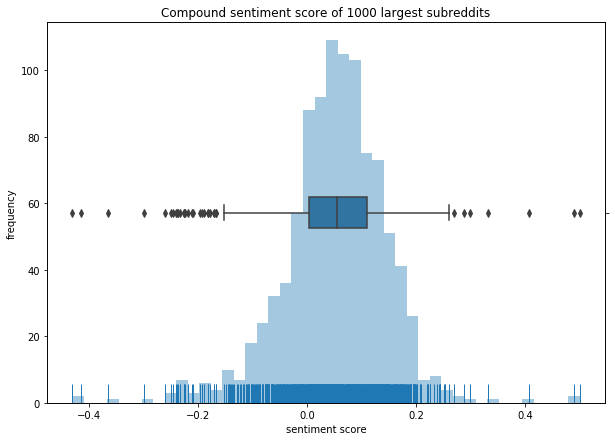

In [320]:
title = 'Compound sentiment score of 1000 largest subreddits'
fig, ax = plt.subplots(figsize=(10,7))

sns.distplot(a=tuple(compound_sentiment['compound']), kde=False, rug=True).set_title(title)
ax2 = ax.twinx()
sns.boxplot(x=compound_sentiment['compound'], ax=ax2)
ax2.set(ylim=(-5, 5))

ax.set_xlabel('sentiment score')
ax.set_ylabel('frequency')

In [345]:
ax.get_figure().savefig('pics/Compound sentiment score of 1000 largest subreddits') 